# LLHP

In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import millefeuille as mf
import pickle
from scipy import stats
from retro.utils.stats import estimate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
parse_dims = ['x', 'y', 'z', 't', 'track_zenith', 'track_azimuth', 'energy', 'track_fraction']
def parse(stats):
    out = {}
    out['mean'] = {}
    out['std'] = {}
    out['mle'] = {}
    out['map'] = {}    
    stats = [s.strip() for s in stats]
    print '\n'.join(stats)
    res = stats[4:12]
    for r in res:
        dim, p, e = [float(x) for x in r.split()]
        out['mean'][parse_dims[int(dim)-1]] = p
        out['std'][parse_dims[int(dim)-1]] = e
    out['mean']['track_energy'] = out['mean']['energy'] * out['mean']['track_fraction']
    out['mean']['cascade_energy'] = out['mean']['energy'] * (1 - out['mean']['track_fraction'])
    out['std']['track_energy'] = out['std']['energy'] * out['mean']['track_fraction']
    out['std']['cascade_energy'] = out['std']['energy'] * (1 - out['mean']['track_fraction'])
    
    res = stats[15:23]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['mle'][parse_dims[int(dim)-1]] = p
    out['mle']['track_energy'] = out['mle']['energy'] * out['mle']['track_fraction']
    out['mle']['cascade_energy'] = out['mle']['energy'] * (1 - out['mle']['track_fraction'])
    
    res = stats[26:34]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['map'][parse_dims[int(dim)-1]] = p
    out['map']['track_energy'] = out['map']['energy'] * out['map']['track_fraction']
    out['map']['cascade_energy'] = out['map']['energy'] * (1 - out['map']['track_fraction'])
    
    return out

In [14]:
# this looks nice
#event = 190
#quite nice one
#event = 33
# this one's fucked
#event = 142
#this one's spot on 80 GeV
#event = 133
# a normal one
event = 7

#failed
#event = 42
#event = 41
#event = 55

#bad
#event = 80

#llhp_data = np.load('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-llhp.npy'%event)
llhp_data = np.load('/data/justin/retro/recos/2018-03-28/tblptckvlog/0/evt%i-llhp.npy'%event)

new_names = ('llh', 'z', 'track_azimuth', 'track_zenith', 'track_energy', 'y', 'cascade_energy', 't', 'x')

#llhp_data.dtype.names = new_names

data = mf.DataStack('data')
llhp = mf.PointLayer(llhp_data, 'llhp')
data.add_layer(llhp)

#with open('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-stats.dat'%event, 'r') as f:
with open('/data/justin/retro/recos/2018-03-26/1460/0/evt%i-stats.dat'%event, 'r') as f:
    mn_stats = f.readlines()
mn_stats = parse(mn_stats)

with open('/data/icecube/sim/ic86/retro/1460/0/mc_truth.pkl', 'rb') as f:
    truth = pickle.load(f)
    
truth = truth[event]
truth['track_azimuth'] = truth['azimuth']
truth['track_zenith'] = np.arccos(truth['coszen'])
truth['track_energy'] = truth['highest_energy_daughter_energy']
truth['t'] = truth['time']

Nested Sampling Global Log-Evidence           :   -0.728797278324210652E+03  +/-    0.354499237593390359E+00
Nested Importance Sampling Global Log-Evidence:   -0.731688587249932311E+03  +/-    0.104989147723792739E+00

Dim No.       Mean        Sigma
1    0.820301780163746486E+01    0.998083063695439598E+01
2   -0.151620219968530101E+02    0.946629418404157796E+01
3   -0.324413576842086684E+03    0.707233325455041850E+01
4    0.974338300817636264E+04    0.240921054725999717E+02
5    0.173428617091874671E+01    0.496327069277837762E+00
6    0.430897778965859590E+01    0.214099187249056255E+01
7    0.952910173753986456E+01    0.274470438230150249E+01
8    0.427040452775737933E+00    0.221490233040965462E+00

Maximum Likelihood Parameters
Dim No.        Parameter
1    0.875691159993073143E+01
2   -0.144675087901921415E+02
3   -0.320522710253806281E+03
4    0.976464527043899943E+04
5    0.155551940605052152E+01
6    0.598959669700747988E+01
7    0.898728513493842307E+01
8    0.344721942018

In [15]:
llhp_data['track_zenith']

array([ 0.64734322,  1.7082485 ,  2.37455249, ...,  1.92807281,
        2.30025315,  1.98914218], dtype=float32)

In [16]:
np.percentile(data['llhp']['track_zenith'], 90)

2.3842466592788698

In [17]:
bin_edges = OrderedDict()
lower_q = 10
upper_q = 90

dims = ['x', 'y', 'z', 't', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy']

#for dim in dims:
#    if dim == 'track_azimuth':
#        mean = stats.circmean(data['llhp'][dim])
#    else:
#        mean = data['llhp'][dim].mean()
#    std = data['llhp'][dim].std()
#    #bin_edges[dim] = np.linspace(np.percentile(data['llhp'][dim], 10), np.percentile(data['llhp'][dim], 90), 101)
#    bin_edges[dim] = np.linspace(mean - std, mean + std, 101)

bin_edges['x'] = np.linspace(truth['x'] - 50 , truth['x'] + 50, 101)
bin_edges['y'] = np.linspace(truth['y'] - 50 , truth['y'] + 50, 101)
bin_edges['z'] = np.linspace(truth['z'] - 50 , truth['z'] + 50, 101)
bin_edges['t'] = np.linspace(truth['t'] - 150 , truth['t'] + 150, 101)
bin_edges['track_azimuth'] = np.linspace(0, 2*np.pi, 101)
bin_edges['track_zenith'] = np.linspace(0, np.pi, 101)
bin_edges['track_energy'] = np.linspace(0 , 50, 101)
bin_edges['cascade_energy'] = np.linspace(0 , 50, 101)
binning = mf.Binning(bin_edges)

In [18]:
data.add_layer(mf.BinLayer(binning['x','y'], 'xy'))
data.add_layer(mf.BinLayer(binning['x','t'], 'xt'))
data.add_layer(mf.BinLayer(binning['x','z'], 'xz'))
data.add_layer(mf.BinLayer(binning['t','z'], 'tz'))
data.add_layer(mf.BinLayer(binning['track_azimuth','track_zenith'], 'azzen'))
data.add_layer(mf.BinLayer(binning['track_energy','track_zenith'], 'ezen'))
data.add_layer(mf.BinLayer(binning['t','track_energy'], 'ten'))
data.add_layer(mf.BinLayer(binning['t','track_zenith'], 'tzen'))
data.add_layer(mf.BinLayer(binning['cascade_energy','track_energy'], 'energy'))

In [19]:
binlayers = ['xy', 'tz', 'xt', 'xz', 'azzen', 'energy', 'ten', 'tzen', 'ezen']

In [20]:
for binlayer in binlayers:
    data.translate(var='llh', source='llhp', dest=binlayer, method='max')
    data.translate(var='llh', dest_var='count', source='llhp', dest=binlayer, method='count')
    data.translate(var='llh', dest_var='sum', source='llhp', dest=binlayer, method='sum')
    data.translate(var='llh', dest_var='mean', source='llhp', dest=binlayer, method='mean')
    data[binlayer]['sum'] = data[binlayer]['sum'] * -1
    data[binlayer]['mean'] = data[binlayer]['mean'] * -1

In [40]:
def plot_map(layer, ax, var='llh', best=True, truth=None, stats=None, estimator=None, est_var = 'median', **kwargs):
    X, Y = layer.meshgrid
    Z = layer[var].T
    ax.set_xlabel(layer.binning.bin_names[0])
    ax.set_ylabel(layer.binning.bin_names[1])
    pc = ax.pcolormesh(X, Y, Z, cmap='Spectral_r', **kwargs)
    plt.colorbar(pc, ax=ax, label=var)
    if best:
        best = np.where(Z==np.max(Z))
        ax.scatter(X[best], Y[best],c='w',marker='*')
        #print X[best], Y[best]
    if truth is not None:
        ax.scatter(truth[layer.binning.bin_names[0]],
                   truth[layer.binning.bin_names[1]],
                   100,
                   marker='+', c='cyan')
    if stats is not None:
        ax.errorbar(stats['mean'][layer.binning.bin_names[0]],
                    stats['mean'][layer.binning.bin_names[1]],
                    xerr=stats['std'][layer.binning.bin_names[0]],
                    yerr=stats['std'][layer.binning.bin_names[1]],
                    marker='.', c='k', ms=0.1)
        ax.errorbar(stats['mle'][layer.binning.bin_names[0]],
                    stats['mle'][layer.binning.bin_names[1]],
                    marker='*', c='w', ms=5)
        ax.errorbar(stats['map'][layer.binning.bin_names[0]],
                    stats['map'][layer.binning.bin_names[1]],
                    marker='x', c='k', ms=5)
    if estimator is not None:
        
        
        ax.errorbar(estimator[est_var][layer.binning.bin_names[0]],
                    estimator[est_var][layer.binning.bin_names[1]],
                    marker='o',
                    c='magenta',
                    ms=5)
        ax.errorbar(estimator['low'][layer.binning.bin_names[0]],
                    estimator[est_var][layer.binning.bin_names[1]],
                    marker='>',
                    c='magenta',
                    ms=5)
        ax.errorbar(estimator['high'][layer.binning.bin_names[0]],
                    estimator[est_var][layer.binning.bin_names[1]],
                    marker='<',
                    c='magenta',
                    ms=5)
        ax.errorbar(estimator[est_var][layer.binning.bin_names[0]],
                    estimator['low'][layer.binning.bin_names[1]],
                    marker='^',
                    c='magenta',
                    ms=5)
        ax.errorbar(estimator[est_var][layer.binning.bin_names[0]],
                    estimator['high'][layer.binning.bin_names[1]],
                    marker='v',
                    c='magenta',
                    ms=5)
    ax.set_xlim(layer.binning[0][0],layer.binning[0][-1])
    ax.set_ylim(layer.binning[1][0],layer.binning[1][-1])

In [68]:
estimator = estimate(data['llhp'].data, percentile_nd=0.95)
#print estimator

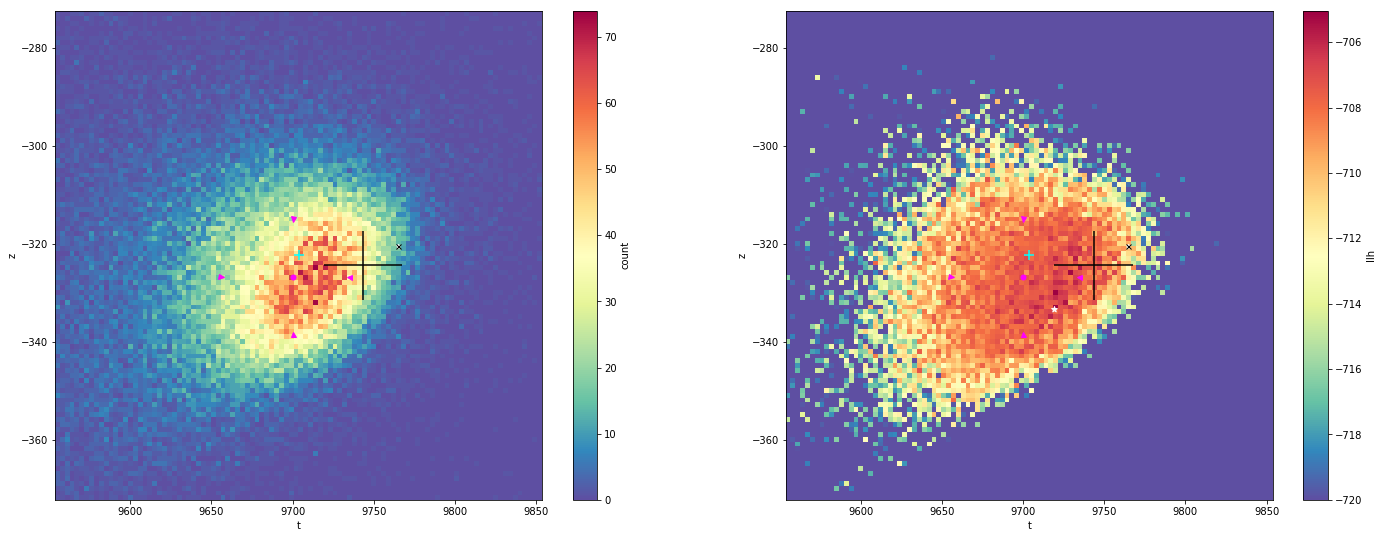

In [73]:
fig, axes = plt.subplots(figsize=(24, 9), ncols=2, nrows=1)
layer = 'tz'
plot_map(data[layer], axes[0], var='count', vmin =0, truth=truth, stats=mn_stats, best=False, estimator=estimator, est_var='median')
plot_map(data[layer], axes[1], var='llh', vmin=-720, truth=truth, stats=mn_stats, best=True, estimator=estimator, est_var='median')

In [16]:
truth

OrderedDict([('pdg', -14),
             ('x', 166.00375876601564),
             ('y', 47.75865582444311),
             ('z', -324.7268327006121),
             ('time', 9554.061774446025),
             ('energy', 31.22145863058618),
             ('coszen', 0.79369186678801007),
             ('azimuth', 0.8929531151525705),
             ('unique_id', 140000010103111),
             ('highest_energy_daughter_pdg', -13),
             ('highest_energy_daughter_energy', 29.00230931556597),
             ('highest_energy_daughter_length', 104.05682878288889),
             ('highest_energy_daughter_coszen', 0.78648816548868949),
             ('highest_energy_daughter_azimuth', 0.9131616331541856),
             ('longest_daughter_pdg', -13),
             ('longest_daughter_energy', 29.00230931556597),
             ('longest_daughter_length', 104.05682878288889),
             ('longest_daughter_coszen', 0.78648816548868949),
             ('longest_daughter_azimuth', 0.9131616331541856),
          

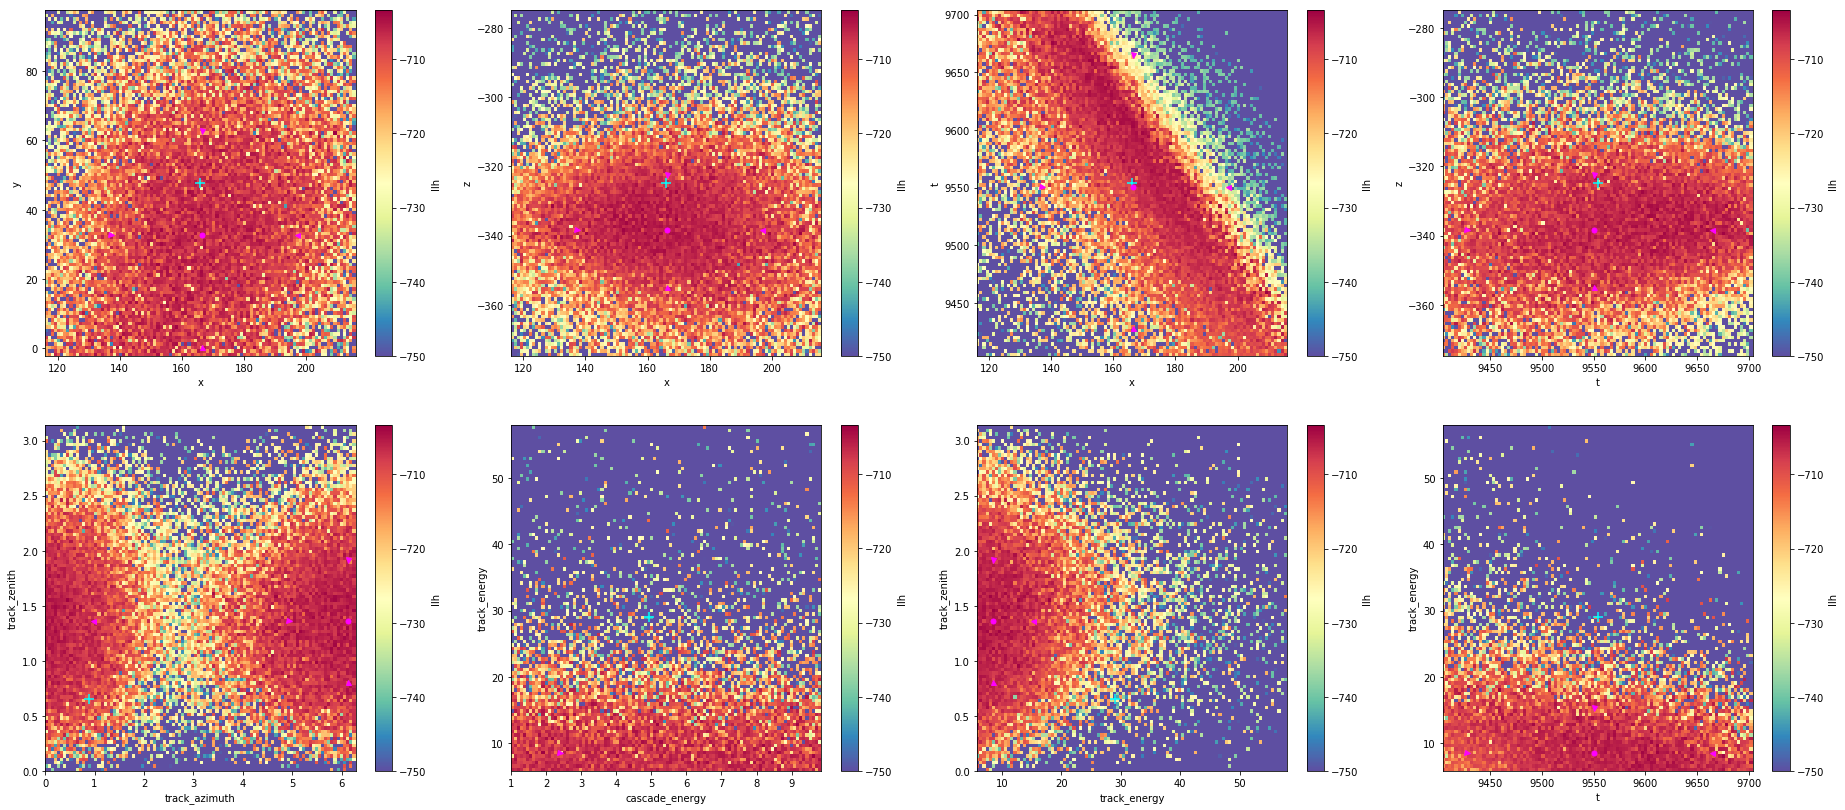

In [19]:
fig, axes = plt.subplots(figsize=(32, 14), ncols=4, nrows=2)
kwargs = {'vmin':-750, 'truth':truth, 'estimator':estimator, 'best':False} #, 'stats': mn_stats}
plot_map(data['xy'], axes[0,0], **kwargs)
plot_map(data['xz'], axes[0,1], **kwargs)
plot_map(data['xt'], axes[0,2], **kwargs)
plot_map(data['tz'], axes[0,3], **kwargs)
plot_map(data['azzen'], axes[1,0], **kwargs)
plot_map(data['energy'], axes[1,1], **kwargs)
plot_map(data['ezen'], axes[1,2], **kwargs)
plot_map(data['ten'], axes[1,3], **kwargs)

In [126]:
mn_stats

{'map': {'cascade_energy': 0.03875257748870347,
  'energy': 0.5908078104471909,
  't': 3346.522689691279,
  'track_azimuth': 2.4161452007743627,
  'track_energy': 0.5520552329584875,
  'track_fraction': 0.9344074726104736,
  'track_zenith': 0.8688395336079782,
  'x': 521.8113827705383,
  'y': -31.997295022010803,
  'z': -363.3730125427246},
 'mean': {'cascade_energy': 31.143160300012806,
  'energy': 63.99131576401881,
  't': 8247.009149965874,
  'track_azimuth': 3.168544646713854,
  'track_energy': 32.848155464006,
  'track_fraction': 0.5133220824078748,
  'track_zenith': 1.540633056447536,
  'x': 17.808455595584128,
  'y': 21.159974156026585,
  'z': 11.465220008891292},
 'mle': {'cascade_energy': 0.9629221212659805,
  'energy': 13.403751039938362,
  't': 5367.741356706363,
  'track_azimuth': 2.3652635523894734,
  'track_energy': 12.44082891867238,
  'track_fraction': 0.9281602501869202,
  'track_zenith': 1.2288741061317192,
  'x': 501.70447766780853,
  'y': -300.77493965625763,
  'z':